Using GPU: NVIDIA GeForce RTX 4070 with CUDA version 12.4
Epoch [1/100], Train Loss: 1.0965, Test Loss: 1.0925, Test Accuracy: 41.78%
Epoch [2/100], Train Loss: 1.0790, Test Loss: 1.0875, Test Accuracy: 35.27%
Epoch [3/100], Train Loss: 1.0580, Test Loss: 1.0871, Test Accuracy: 40.75%
Epoch [4/100], Train Loss: 1.0305, Test Loss: 1.0797, Test Accuracy: 39.73%
Epoch [5/100], Train Loss: 1.0171, Test Loss: 1.0734, Test Accuracy: 42.12%
Epoch [6/100], Train Loss: 0.9953, Test Loss: 1.0655, Test Accuracy: 44.18%
Epoch [7/100], Train Loss: 0.9814, Test Loss: 1.0584, Test Accuracy: 47.60%
Epoch [8/100], Train Loss: 0.9588, Test Loss: 1.0506, Test Accuracy: 46.23%
Epoch [9/100], Train Loss: 0.9301, Test Loss: 1.0429, Test Accuracy: 49.66%
Epoch [10/100], Train Loss: 0.9180, Test Loss: 1.0358, Test Accuracy: 49.32%
Epoch [11/100], Train Loss: 0.8977, Test Loss: 1.0323, Test Accuracy: 49.32%
Epoch [12/100], Train Loss: 0.8799, Test Loss: 1.0216, Test Accuracy: 52.05%
Epoch [13/100], Train Loss:

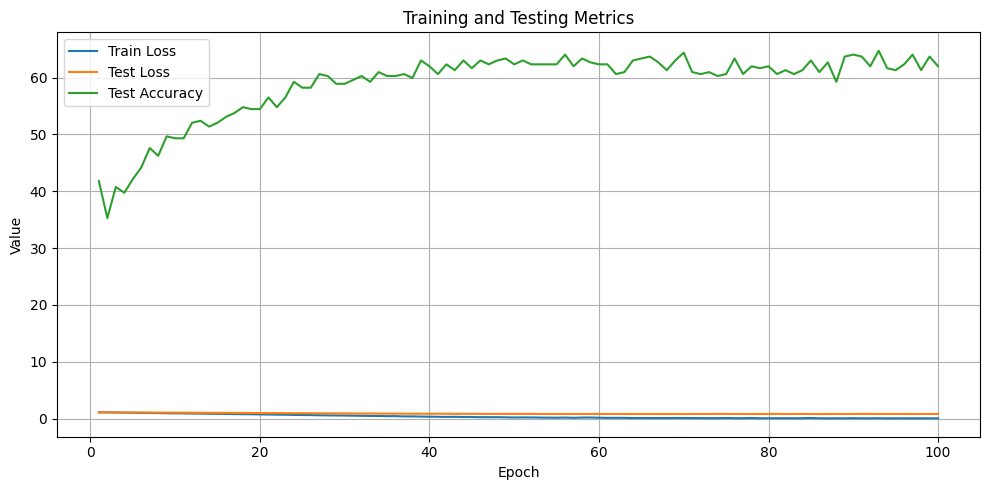

Real image "Up.jpg" predicted as "Center".
Real image "Down.jpg" predicted as "Center".
Real image "Center.jpg" predicted as "Up".
Evaluation on real images complete.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import onnx
import onnxruntime as ort
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
from torch.amp import GradScaler, autocast

# Define paths
base_dir = '/mnt/c/Users/rober/Desktop/GazeDetectionStudy'
dataset_dir = os.path.join(base_dir, 'natural_dataset')
real_eyes_dir = os.path.join(dataset_dir, 'real_eyes_for_testing')
model_save_dir = os.path.join(base_dir, 'models', 'natural_resnet')
os.makedirs(model_save_dir, exist_ok=True)

# Parameters
batch_size = 32  # Batch size for better GPU utilization
num_epochs = 100
learning_rate = 0.000001
num_classes = 3

# Data transforms (no augmentation for simplicity)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load training and testing datasets
train_dataset = datasets.ImageFolder(os.path.join(dataset_dir, 'train'), transform=data_transforms)
test_dataset = datasets.ImageFolder(os.path.join(dataset_dir, 'test'), transform=data_transforms)

# Optimized DataLoader with pin_memory and num_workers
num_workers = min(8, os.cpu_count())  # Use a high number of workers to speed up data loading
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

# Load pre-trained ResNet-152 model and modify for 3 classes
model = models.resnet152(weights='ResNet152_Weights.IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Print CUDA device information
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)} with CUDA version {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU for training.")

# Enable CuDNN benchmarking for performance optimization
torch.backends.cudnn.benchmark = True

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scaler = GradScaler()  # For mixed-precision training

# Training loop
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        # Print epoch and batch number every 100 batches
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}]")

    train_losses.append(running_loss / len(train_loader))
    
    # Evaluation on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Mixed precision for evaluation
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

# Save the model in .pth format
pth_model_path = os.path.join(model_save_dir, 'natural_resnet_gaze.pth')
torch.save(model.state_dict(), pth_model_path)
print(f'Model saved to {pth_model_path}')

# Export to ONNX
onnx_model_path = os.path.join(model_save_dir, 'natural_resnet_gaze.onnx')
dummy_input = torch.randn(1, 3, 224, 224, device=device)
torch.onnx.export(
    model, dummy_input, onnx_model_path, 
    input_names=['input'], output_names=['output'], 
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=14
)
print(f'Model exported to ONNX format at {onnx_model_path}')

# Verify ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

# Training Visualization with Seaborn
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Test Accuracy': test_accuracies
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='Train Loss', data=df, label='Train Loss')
sns.lineplot(x='Epoch', y='Test Loss', data=df, label='Test Loss')
sns.lineplot(x='Epoch', y='Test Accuracy', data=df, label='Test Accuracy')
plt.title('Training and Testing Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate on real images
class_names = ['Up', 'Down', 'Center']
model.eval()

for cls in class_names:
    image_path = os.path.join(real_eyes_dir, f'{cls}.jpg')
    if os.path.exists(image_path):
        image = Image.open(image_path)
        image = data_transforms(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
            predicted_class = class_names[predicted.item()]
        
        print(f'Real image "{cls}.jpg" predicted as "{predicted_class}".')

print("Evaluation on real images complete.")
